# Experiments and Shit
This is the code used to produce figures 3-8. Run cells sequentially.

In [ ]:
# We revert back to the old TensorFlow to avoid eager execution errors

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
from keras import backend as K
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Dropout
from keras import initializers, regularizers, models, optimizers, callbacks
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.25); sns.set_style("whitegrid");
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
import random

Using TensorFlow backend.


### Util Functions

In [ ]:
random.seed(0)
np.random.seed(0)

def display(xlabel="", ylabel="", title="", legend=False, colorbar=False, ticks=True, xscale="linear", yscale="linear", show=True):
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    if colorbar:
        plt.colorbar()
    if not ticks:
        plt.tick_params(axis='both', width='0',labelsize='0')
    if show:
        plt.show()
    
def svd(X, k): # gives singular value decomposition
    U, S, V = np.linalg.svd(X, full_matrices=False)
    loss = np.sum((X - U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:]))**2)
    return U[:,:k], S[:k], V[:k,:].T, loss

def hyperparameters(learning_rate=1e-3, decay=1e-3, epochs=10, batch_size=32):
    return {
        'lr': learning_rate,
        'dr': decay,
        'ep': epochs,
        'bs': batch_size,
    }

### Autoencoder Model

In [ ]:
# Defining the regularised loss functions

def regularization(W1, W2, constant, method):
    # Method == 0 is unregularized
    # Method == 1 is the product loss
    if method == 1:
        return constant * K.sum(K.square(K.dot(W1,W2)))
    # Method == 2 is the sum loss
    elif method == 2:
        return constant * (K.sum(K.square(W1)) + K.sum(K.square(W2)))
    elif method == 3:
        return constant/2 * (K.sum(K.square(W1)) + K.sum(K.square(W2))) + constant/2 * K.sum(K.square(K.dot(W1,W2)))
    elif method == 4:
        return constant/20 * (K.sum(K.square(W1)) + K.sum(K.square(W2))) + 19*constant/20 * K.sum(K.square(K.dot(W1,W2))) 
    elif method == 4:
        return constant/200 * (K.sum(K.square(W1)) + K.sum(K.square(W2))) + 199*constant/200 * K.sum(K.square(K.dot(W1,W2)))          
    else:
        return 0

def LAE(m, k, constant=0, method=0, bias=True, stddev=0.05):
    
    encode_layer = Dense(k, activation='linear', use_bias=bias, kernel_initializer=initializers.RandomNormal(stddev=stddev))
    dropout_layer = Dropout(rate=np.sqrt(1.0/(1.0 + constant)))
    decode_layer = Dense(m, activation='linear', use_bias=bias, kernel_initializer=initializers.RandomNormal(stddev=stddev))
    
    X = Input(shape=(m,))
    Z = encode_layer(X)
    Y = decode_layer(Z)
    
    autoencoder = models.Model(X,Y)
    
    W1 = encode_layer.trainable_weights[0]
    W2 = decode_layer.trainable_weights[0]
    autoencoder.add_loss(regularization(W1, W2, constant, method))
    
    
    return autoencoder

### Training

In [ ]:
class logger(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.weight_difference = []

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        
        parameters = self.model.get_weights()
        if len(parameters) == 4:
            W1, _, W2, _ = parameters
        else:
            W1, W2 = parameters
        self.weight_difference.append(np.sum((W1 - W2.T)**2))

def square_error(x, y):
    return K.sum(K.square(x - y))
        
def train(X, model, hp, callbacks=[], shuffle=True, verbose=0):
    model.compile(optimizer=optimizers.Adam(lr=hp['lr'], decay=hp['dr']), loss=square_error)   
    model.fit(X, X, epochs=hp['ep'], batch_size=hp['bs'], shuffle=shuffle, verbose=verbose, callbacks=callbacks)

## Synthetic Data

### Generate Data

In [ ]:
# We use the QR factorisation to decompose U = QR
# Here, U is an nxn matrix with random entries N(0,1)
# We have Q is orthonormal, so we only take that
# We take a zero matrix and then fill it up with diagonal entries

def generate(n, m, sigma):
    Ux, _ = np.linalg.qr(np.random.randn(n,n));   
    Vx, _ = np.linalg.qr(np.random.randn(m,m));  
    Sx = np.zeros((n,m))
    for i, val in enumerate(sigma):
        Sx[i,i] = val/5
    return Ux.dot(Sx).dot(Vx.T)

# The returned SVD is our X. 

In [ ]:
n, m  = 30, 20
X = generate(n, m, np.arange(1, m + 1))

# np.arange returns evenly spaced values 1, 2, ..., m

### Model Parameters

In [ ]:
k = 8
alpha = 10
hp = hyperparameters(learning_rate=5e-2, decay=1e-1, epochs=4000, batch_size=n)

### Transpose Theorem

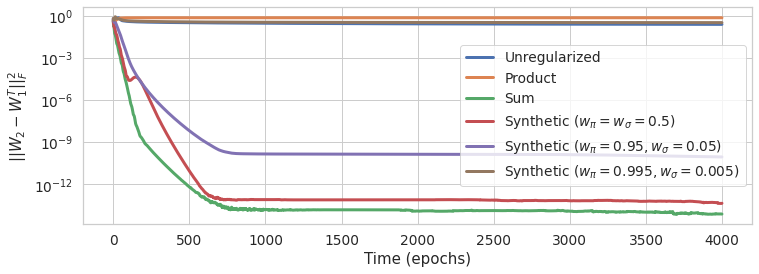

In [ ]:
plt.rcParams['figure.figsize'] = [12, 4]
methods = ['Unregularized', 'Product', 'Sum', 'Synthetic $(w_{\pi} = w_{\sigma} = 0.5)$', 'Synthetic $(w_{\pi} = 0.95, w_{\sigma} = 0.05)$', 'Synthetic $(w_{\pi} = 0.995, w_{\sigma} = 0.005)$']
for index, method in enumerate(methods):
    
    # train
    autoencoder = LAE(m, k, alpha, index, bias = False)
    log = logger()
    train(X, autoencoder, hp, callbacks=[log], shuffle=False)
    
    # plot
    plt.plot(log.weight_difference, label=method, lw=3)
display(yscale='log', legend=True, show=False)
plt.yticks([1e-0,1e-3,1e-6,1e-9,1e-12])
plt.xticks([0,500,1000,1500,2000,2500,3000,3500,4000])
plt.xlabel('Time (epochs)')
plt.ylabel('$||W_2 - W_{1}^{T}||_{F}^{2}$')
plt.show()

### Relationship between Singular Vectors of X and W (V)

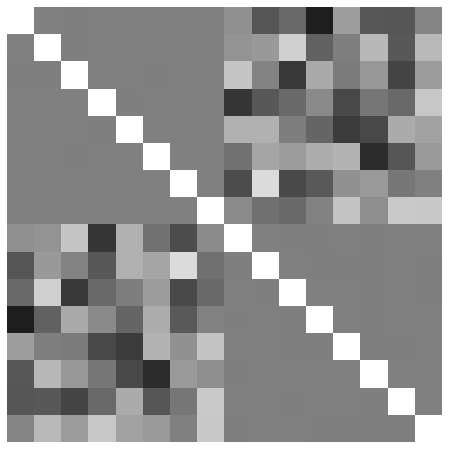

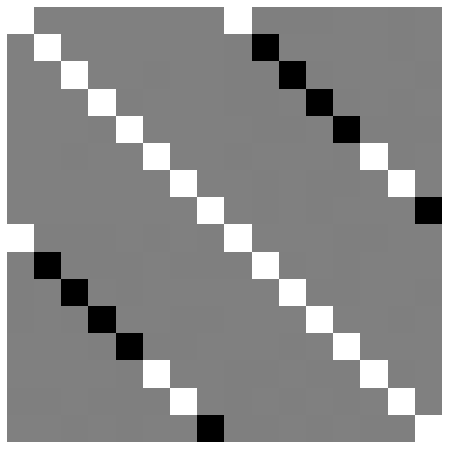

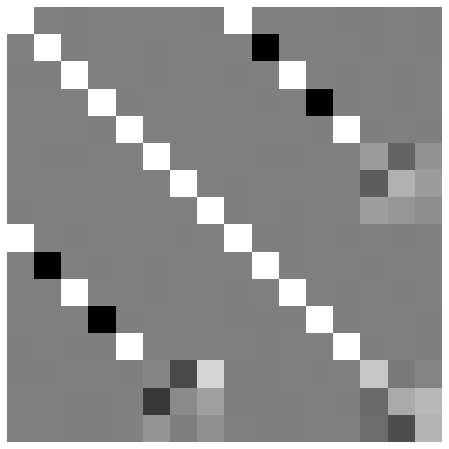

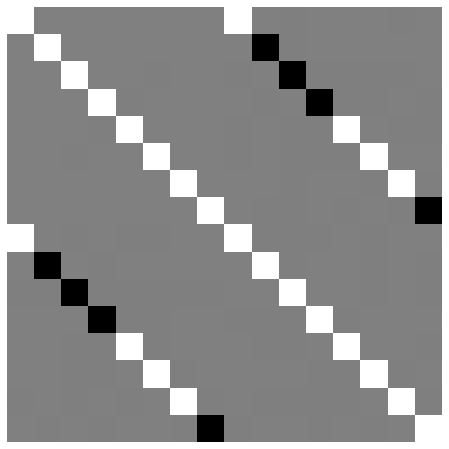

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]
methods = ['No Reg', 'Product Reg', 'Sum Reg', 'Synthetic']

_, _, VX, _ = svd(X, k)

for index, method in enumerate(methods):
    
    # train
    autoencoder = LAE(m, k, alpha, index, bias=False)
    train(X, autoencoder, hp, shuffle=False)
    W1, W2 = autoencoder.get_weights()
    UW, _, VW, _ = svd(W1 @ W2, k)
    
    # compute vectors
    A = np.concatenate((VX.T, UW.T), axis=0)
    B = np.concatenate((VX, VW), axis=1)
        
    # plot outer product
    plt.imshow(A @ B, cmap='gray', label = 'method')
    plt.clim(-1,1)
    plt.axis('off')
    plt.show()

### Singular Value Shrinkage of W (S)

In [ ]:
def shrinkage(alpha, X, k, method):
    if method == 1:
        _, S, _, _ = svd(X, k)
        return 1.0 / (np.ones(k) + alpha / S**2)
    elif method == 2:
        _, S, _, _ = svd(X, k)
        return np.maximum(np.zeros(k), np.ones(k) - alpha / S**2)
    else:
        return np.ones(k)

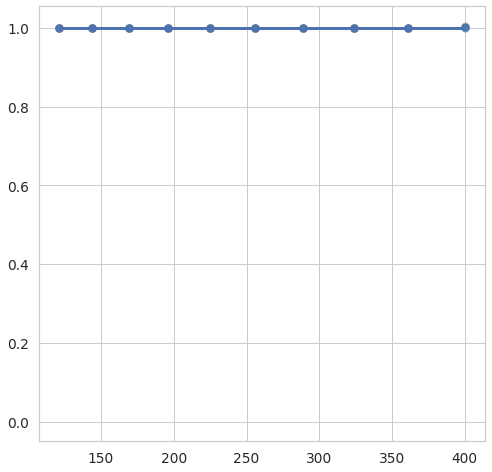

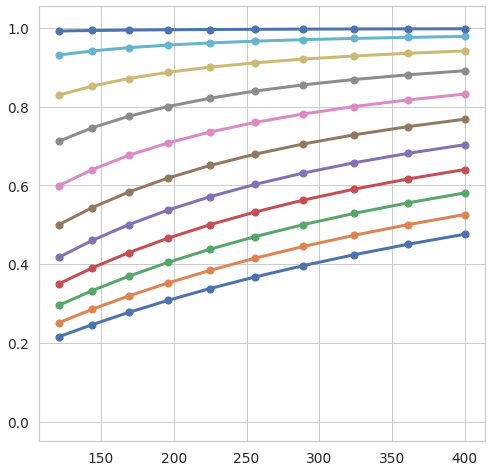

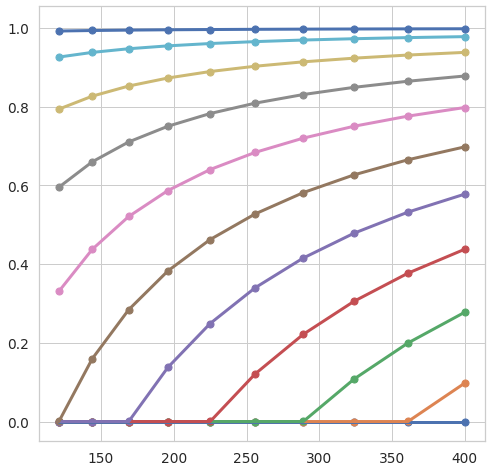

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]
ax = None
methods = ['No Reg', 'Product Reg', 'Sum Reg']

# hyperparameters
alphas = (np.arange(1,22,2)**2)[::-1]

_, SX, _, _ = svd(X, k)

for index, method in enumerate(methods):
    fig = plt.figure()
    ax = plt.subplot(111, sharey=ax)
    for a in alphas:

        # train
        autoencoder = LAE(m, k, a, index, bias=False)
        train(X, autoencoder, hp, shuffle=False)
        W1, W2 = autoencoder.get_weights()
        W = W1 @ W2
        _, SW_empirical, _, _ = svd(W, k)
        SW_theory = shrinkage(a, X, k, index)

        # plot
        plt.scatter(SX**2, SW_empirical, label=str(a), s=50)
        plt.plot(SX**2, SW_theory, linewidth=3, label = method)
display()

## CIFAR-10 Dataset

170500096/170498071 [==============================] - 2s 0us/step
(10000, 32, 32)


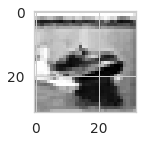

In [ ]:
import matplotlib.pyplot as plt
# We need to load the CIFAR dataset as follows:
# (train_X, train_y), (test_X, test_y) = mnist.load_data()
(_, _), (X, Y) = tf.keras.datasets.cifar10.load_data()               

# The testing set has 10,000 images, each which are 28x28 pixels
# There is also an additional dimension: with R, G, B respectively
# Therefore, X.shape is (10000, 28, 28)
# n is the number of examples, w is width and h is height

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    rst = np.squeeze(rst)
    # rst = np.expand_dims(rst, axis=3)
    return rst

X = grayscale(X)
print(X.shape)
n, w, h = X.shape 
m = w * h

# We then want X to be an n x m array.
# In MNIST, there are 784 inputs and each value is between 0-255 (single grayscale)
# We divide by 255 to normalize this

img = 150
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(X[img], interpolation='none', cmap=plt.get_cmap('gray'))

X = np.reshape(X,[n, m]).astype('float32') / 255


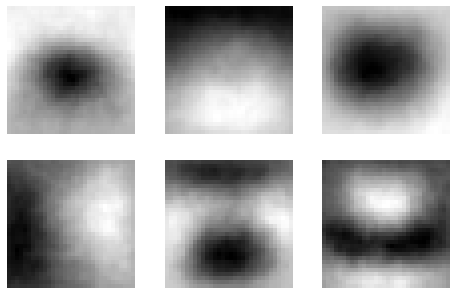

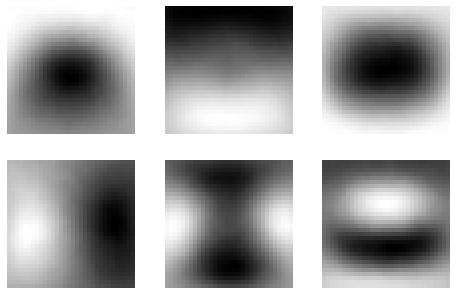

In [ ]:
k = 6
alpha = 20
hp = hyperparameters(learning_rate=5e-2, decay=1e-3, epochs=400, batch_size=32)

plt.rcParams['figure.figsize'] = [8, 8]
methods = ['Sum Reg', 'PCA']

for index, method in enumerate(methods):
    
    # train
    if method == 'PCA':
        pca = PCA(n_components=k)
        pca = pca.fit(X)
        V = pca.components_.T
        
    else:
        autoencoder = LAE(m, k, alpha, index, bias=True, stddev=1)
        train(X, autoencoder, hp)
        W1, _, W2, _ = autoencoder.get_weights()
        _, S, V, _ = svd(W2, k)
        V = V[:,np.argsort(S)[::-1]]
        
    # plot weights
    V = V.reshape([w, h, k], order='C')
    side = int(np.ceil(np.sqrt(k)))
    for i in range(k):
        plt.subplot(side, side, i + 1)
        plt.imshow(V[:, :, i], cmap='gray')
        plt.axis('off')
    plt.show()

### Embeddings

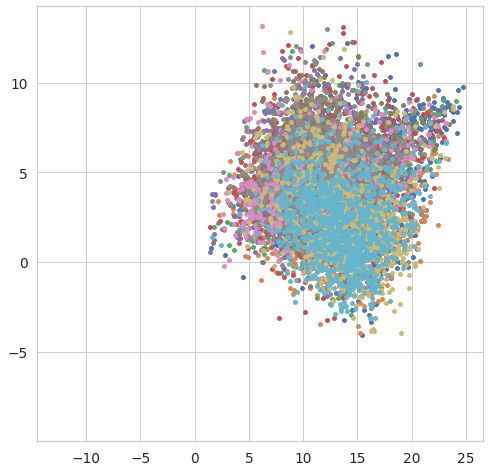

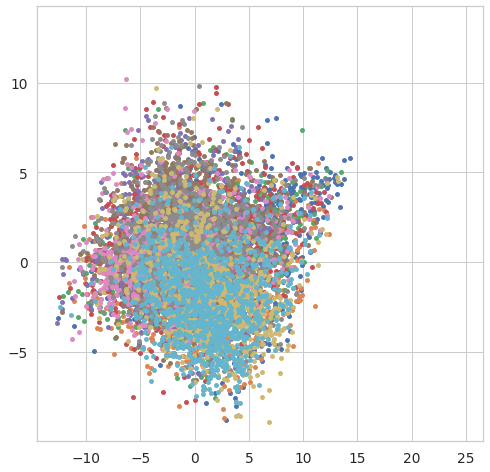

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]
methods = ['Sum Reg', 'PCA']
ax = None

k = 2

for index, method in enumerate(methods):
    
    # train
    if method == 'PCA':
        pca = PCA(n_components=k)
        embedding = pca.fit_transform(X)
    else:
        autoencoder = LAE(m, k, alpha, 2, bias=True)
        train(X, autoencoder, hp)
        W1, _, _, _ = autoencoder.get_weights()
        embedding = X @ W1
    
    # plot embeddings
    fig = plt.figure()
    ax = plt.subplot(111, sharex=ax, sharey=ax)
    for c in np.unique(Y):
        idx = np.where(Y == c)
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, s=15)
    display('', '', '', legend=False, show=False)
plt.show()

## Fashion MNIST dataset


In [ ]:
# We need to load the MNIST dataset as follows:
# (train_X, train_y), (test_X, test_y) = mnist.load_data()
fashion_mnist = tf.keras.datasets.fashion_mnist
(_, _), (X, Y) = fashion_mnist.load_data()         

# The testing set has 10,000 images, each which are 28x28 pixels
# Therefore, X.shape is (10000, 28, 28)
# n is the number of examples, w is width and h is height
print(X.shape)
n, w, h = X.shape 
m = w * h

# We then want X to be an n x m array.
# In MNIST, there are 784 inputs and each value is between 0-255 (single grayscale)
# We divide by 255 to normalize this
X = np.reshape(X,[n, m]).astype('float32') / 255

4423680/4422102 [==============================] - 0s 0us/step
(10000, 28, 28)


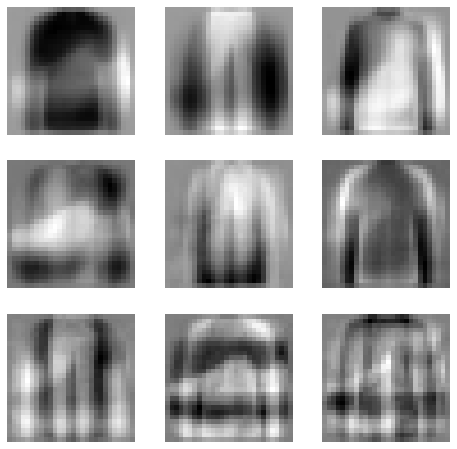

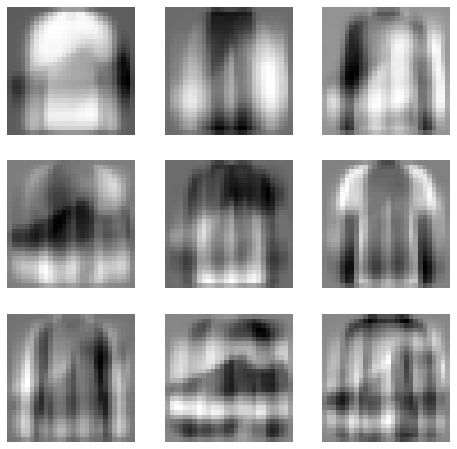

In [ ]:
k = 9
alpha = 10
hp = hyperparameters(learning_rate=5e-2, decay=1e-3, epochs=200, batch_size=32)

plt.rcParams['figure.figsize'] = [8, 8]
methods = ['Sum Reg', 'PCA']

for index, method in enumerate(methods):
    
    # train
    if method == 'PCA':
        pca = PCA(n_components=k)
        pca = pca.fit(X)
        V = pca.components_.T
        
    else:
        autoencoder = LAE(m, k, alpha, index, bias=True, stddev=1)
        train(X, autoencoder, hp)
        W1, _, W2, _ = autoencoder.get_weights()
        _, S, V, _ = svd(W2, k)
        V = V[:,np.argsort(S)[::-1]]
        
    # plot weights
    V = V.reshape([w, h, k], order='C')
    side = int(np.ceil(np.sqrt(k)))
    for i in range(k):
        plt.subplot(side, side, i + 1)
        plt.imshow(V[:, :, i], cmap='gray')
        plt.axis('off')
    plt.show()

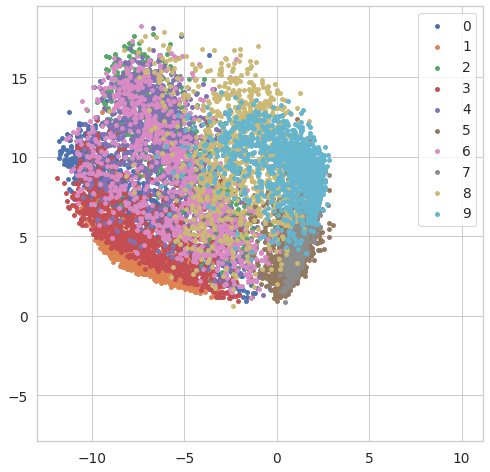

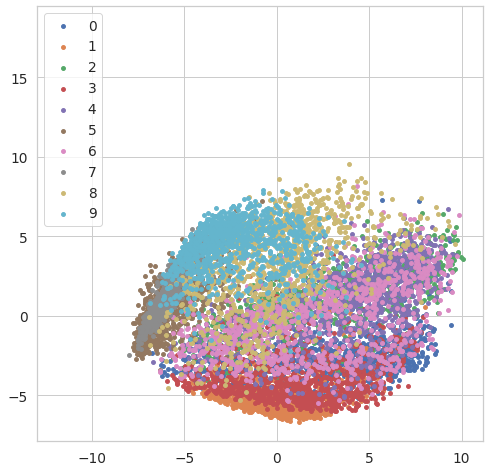

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]
methods = ['Sum Reg', 'PCA']
ax = None

k = 2

for index, method in enumerate(methods):
    
    # train
    if method == 'PCA':
        pca = PCA(n_components=k)
        embedding = pca.fit_transform(X)
    else:
        autoencoder = LAE(m, k, alpha, 2, bias=True)
        train(X, autoencoder, hp)
        W1, _, _, _ = autoencoder.get_weights()
        embedding = X @ W1
    
    # plot embeddings
    fig = plt.figure()
    ax = plt.subplot(111, sharex=ax, sharey=ax)
    for c in np.unique(Y):
        idx = np.where(Y == c)
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, s=15)
    display('', '', '', legend=True, show=False)
plt.show()

In [ ]:
for i, val in enumerate(np.arange(1, 10)):
  print(i, val)



0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
